# Importações


In [5]:
import urllib.request
import os
from PIL import Image,ImageStat
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms

from torch import optim
import sklearn.metrics as metrics

import torch.nn.functional as F



#Rede Convolucional

##MobileNetV3

In [6]:
### Seleciona o dispositivo (GPU se disponível, caso contrário CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
model = torchvision.models.mobilenet_v3_large(weights = torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:03<00:00, 7.17MB/s]


In [8]:
###
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)

In [9]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:

model.classifier[3] = nn.Linear(1280,2)


In [11]:

model.classifier


Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=2, bias=True)
)

##ResNet18

In [ ]:
#model_resnet = torchvision.models.resnet18(pretrained=True)

In [ ]:
#num_ftrs = model_resnet.fc.in_features

In [ ]:
#model_resnet.fc = nn.Linear(num_ftrs, 2)

In [ ]:
#model_resnet = model_resnet.to(device)

#Dataset


In [12]:
main_dir = "/content/drive/MyDrive/Frutas"

In [13]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir(main_dir)

Mounted at /content/drive


In [14]:
!ls

abacate  best_model.pth  mamao


##Loader


In [15]:

def image_loader(img):
    return Image.open(img).convert("RGB")

In [16]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

##Construção da classe Dataset


In [17]:

!ls

abacate  best_model.pth  mamao


In [18]:
dir = './'

In [19]:
for file_names in os.scandir('./'):
    print(file_names)

<DirEntry 'abacate'>
<DirEntry 'mamao'>
<DirEntry 'best_model.pth'>


In [20]:
classes = [d.name for d in os.scandir(dir) if d.is_dir()]

In [21]:
classes

['abacate', 'mamao']

In [22]:
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

In [23]:
class_to_idx

{'abacate': 0, 'mamao': 1}

In [24]:
instances = []
for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                item = path, class_index
                instances.append(item)

In [25]:
instances

[('./abacate/1717549654771.jpg', 0),
 ('./abacate/1717549654794.jpg', 0),
 ('./abacate/1717549654818.jpg', 0),
 ('./abacate/1717549654850.jpg', 0),
 ('./abacate/1717549654876.jpg', 0),
 ('./abacate/1717549654899.jpg', 0),
 ('./abacate/1717549654928.jpg', 0),
 ('./abacate/1717549654956.jpg', 0),
 ('./abacate/1717549654987.jpg', 0),
 ('./abacate/1717549655017.jpg', 0),
 ('./abacate/1717549655049.jpg', 0),
 ('./abacate/1717549655077.jpg', 0),
 ('./abacate/1717549655103.jpg', 0),
 ('./abacate/1717549655132.jpg', 0),
 ('./abacate/1717549655157.jpg', 0),
 ('./abacate/1717549655184.jpg', 0),
 ('./abacate/1717549655212.jpg', 0),
 ('./abacate/1717549655241.jpg', 0),
 ('./abacate/1717549655267.jpg', 0),
 ('./abacate/1717549655294.jpg', 0),
 ('./abacate/1717549655324.jpg', 0),
 ('./abacate/1717549655350.jpg', 0),
 ('./abacate/1717549655380.jpg', 0),
 ('./abacate/1717549655408.jpg', 0),
 ('./abacate/1717549655435.jpg', 0),
 ('./abacate/1717549655466.jpg', 0),
 ('./abacate/1717549655498.jpg', 0),
 

In [26]:
from torch.utils.data import Dataset

from typing import Any,Tuple

class FrutasDataset(Dataset):
    def __init__(self,dir,transform=None,target_transform=None,loader = None):
        self.main_dir = dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.targets = []
        self.instances = self.make_instances()
        self.loader = loader

        if loader is None:
            self.loader = lambda x: Image.open(x).convert('RGB')

    def make_instances(self):
        instances = []
        targets = []
        for target_class in sorted(self.class_to_idx.keys()):
                class_index = self.class_to_idx[target_class]
                target_dir = os.path.join(self.main_dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        targets.append(class_index)
                        instances.append(item)
        self.targets = torch.tensor(targets)
        return instances
    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target
    def __len__(self) -> int:
        return len(self.instances)

In [27]:
dataset = FrutasDataset('./',transform=transform)

In [28]:
len(dataset)

402

In [29]:
np.unique(dataset.targets,return_counts=True)

(array([0, 1]), array([201, 201]))

In [30]:
dataset = torchvision.datasets.DatasetFolder('./',loader = image_loader,extensions='jpg',transform=transform )

In [31]:
dataset.targets = torch.tensor(dataset.targets)

#Treinamento

In [32]:
ds = dataset

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
np.unique(ds.targets,return_counts=True)

(array([0, 1]), array([201, 201]))

In [35]:
ds

Dataset DatasetFolder
    Number of datapoints: 402
    Root location: ./
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [36]:
bs = 32
train_idx, temp_idx = train_test_split(np.arange(len(ds)),test_size=0.3,shuffle=True,stratify=ds.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=ds.targets[temp_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=test_sampler)

In [37]:
np.unique(ds.targets[train_idx],return_counts=True)

(array([0, 1]), array([140, 141]))

In [38]:
np.unique(ds.targets[valid_idx],return_counts=True)

(array([0, 1]), array([30, 30]))

In [39]:
np.unique(ds.targets[test_idx],return_counts=True)

(array([0, 1]), array([31, 30]))

In [40]:
x,y = next(iter(dl_train))

In [41]:
x.shape,y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [42]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [43]:
device

device(type='cuda', index=0)

In [44]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22699MB, multi_processor_count=58)

In [45]:
x.to(device)

tensor([[[[ 1.0159,  0.9817,  0.9474,  ...,  0.7248,  0.7077,  0.7077],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.9988,  0.9817,  0.9988,  ...,  0.7077,  0.7077,  0.7077],
          ...,
          [ 1.0331,  1.0331,  1.0159,  ...,  0.8276,  0.8276,  0.8104],
          [ 1.0331,  1.0331,  1.0159,  ...,  0.8276,  0.8104,  0.8104],
          [ 1.0331,  1.0159,  0.9817,  ...,  0.8104,  0.7933,  0.8104]],

         [[ 1.2031,  1.1856,  1.1331,  ...,  0.8880,  0.8704,  0.8704],
          [ 1.1856,  1.1856,  1.1506,  ...,  0.8880,  0.8529,  0.8704],
          [ 1.1681,  1.1506,  1.1681,  ...,  0.8704,  0.8704,  0.8529],
          ...,
          [ 1.2381,  1.2381,  1.2206,  ...,  1.0280,  1.0105,  0.9930],
          [ 1.2381,  1.2206,  1.2206,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.2381,  1.2206,  1.2031,  ...,  0.9930,  0.9755,  0.9930]],

         [[ 1.1062,  1.0888,  1.0714,  ...,  0.8622,  0.8274,  0.8274],
          [ 1.0888,  1.1062,  

In [46]:
device

device(type='cuda', index=0)

In [47]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22699MB, multi_processor_count=58)

In [48]:
model = torchvision.models.mobilenet_v3_small(weights=torchvision.models.mobilenet.MobileNet_V3_Small_Weights)
#model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.mobilenet.MobileNet_V3_Large_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 130MB/s]


In [49]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [50]:
model.classifier[3] = nn.Linear(1024,2)

In [51]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [52]:
loss_train = []
loss_eval  = []

In [53]:
patience_time = 4

In [54]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.01)

In [55]:
epochs = 10

stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0
while (not stop):
    #wandb.watch(model)
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    lloss = []
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'optim':opt.state_dict(),'model':model.state_dict(),'epoch':epoch,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'best_model.pth')
    last_best_result += 1
    if last_best_result > patience_time:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

Best model found! saving...
epoch 0 loss_train 0.626 loss_eval 0.555 last_best 1
Best model found! saving...
epoch 1 loss_train 0.461 loss_eval 0.477 last_best 1
Best model found! saving...
epoch 2 loss_train 0.349 loss_eval 0.446 last_best 1
Best model found! saving...
epoch 3 loss_train 0.273 loss_eval 0.414 last_best 1
Best model found! saving...
epoch 4 loss_train 0.196 loss_eval 0.393 last_best 1
Best model found! saving...
epoch 5 loss_train 0.170 loss_eval 0.368 last_best 1
Best model found! saving...
epoch 6 loss_train 0.146 loss_eval 0.357 last_best 1
Best model found! saving...
epoch 7 loss_train 0.097 loss_eval 0.335 last_best 1
Best model found! saving...
epoch 8 loss_train 0.086 loss_eval 0.316 last_best 1
Best model found! saving...
epoch 9 loss_train 0.076 loss_eval 0.294 last_best 1
Best model found! saving...
epoch 10 loss_train 0.058 loss_eval 0.288 last_best 1
Best model found! saving...
epoch 11 loss_train 0.053 loss_eval 0.262 last_best 1
Best model found! saving..

In [90]:
recover = torch.load('best_model.pth')
#actual_state = {'optim':opt.state_dict(),'model':model.state_dict(),'epoch':epoch}

In [91]:
opt.load_state_dict(recover['optim'])
model.load_state_dict(recover['model'])
loss_train = recover['loss_train']
loss_eval = recover['loss_eval']
epoch = recover['epoch']

In [92]:
epoch

37

#Avaliação do modelo

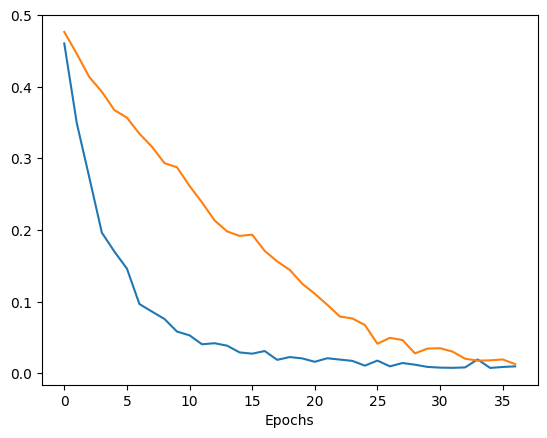

In [93]:
import matplotlib.pyplot as plt


fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [94]:
import sklearn.metrics as metrics

In [95]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [96]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target

In [97]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [98]:
metrics.confusion_matrix(ytrue,lres)

array([[31,  0],
       [ 1, 29]])

In [101]:
metrics.accuracy_score(ytrue,lres)

0.9836065573770492

In [102]:
metrics.precision_score(ytrue,lres)

1.0

In [103]:
metrics.recall_score(ytrue,lres)

0.9666666666666667

In [104]:
metrics.f1_score(ytrue,lres)

0.983050847457627

#Testando com uma imagem nova

##Testando com abacate


In [106]:
!ls

abacate  best_model.pth  mamao


In [83]:
img = image_loader('./abacate/abacate_teste.jpg')

In [73]:
img

Output hidden; open in https://colab.research.google.com to view.

In [84]:
x = transform(img)

In [85]:
x.shape

torch.Size([3, 224, 224])

In [86]:
x= x.view(1,3,224,224)

In [87]:
x.shape

torch.Size([1, 3, 224, 224])

In [107]:
x = x.to(device)

In [115]:
pred = model(x)

In [116]:
pred

tensor([[ 2.4360, -2.6136]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [110]:
pred.argmax(dim=1).cpu().tolist()

[0]

##Testando com mamão

In [117]:
!ls

abacate  best_model.pth  mamao


In [118]:
img = image_loader('./mamao/mamao_teste.jpg')

In [120]:
img

Output hidden; open in https://colab.research.google.com to view.

In [121]:
x = transform(img)

In [122]:
x.shape

torch.Size([3, 224, 224])

In [125]:
x= x.view(1,3,224,224)

In [126]:
x = x.to(device)

In [127]:
pred = model(x)

In [128]:
pred

tensor([[-3.7166,  3.4290]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [129]:
pred.argmax(dim=1).cpu().tolist()

[1]